### Imports

In [ ]:
import requests, io, zipfile, random
import geopandas as gpd
import pytz
import numpy as np
from datetime import datetime
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, plot_importance, plot_tree as xg_plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

### Data Acquisition & Preprocessing

In [ ]:
req = requests.get("https://github.com/evansiroky/timezone-boundary-builder/releases/download/2025b/timezones-with-oceans-now.geojson.zip", headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/139.0.0.0 Safari/537.36"})

if req.status_code == 200:
    zip_file = zipfile.ZipFile(io.BytesIO(req.content))
    zip_file.extractall()
else:
    print(f"Failed to download file. Status code: {req.status_code}")

In [ ]:
gdf = gpd.read_file("combined-with-oceans-now.json")
gdf.shape

(92, 2)

In [ ]:
gdf_projected = gdf.to_crs(epsg=3395)
gdf_projected["centroid"] = gdf_projected.geometry.centroid
gdf["centroid"] = gdf_projected["centroid"].to_crs(epsg=4326)

gdf["longitude"] = gdf["centroid"].x
gdf["latitude"] = gdf["centroid"].y

def get_utc_offset(tzid):
    try:
        if tzid.startswith("Etc/GMT"):
            offset = float(tzid.split("Etc/GMT")[1])
            return -offset

        tz = pytz.timezone(tzid)
        offset_timedelta = tz.utcoffset(datetime.now())
        return offset_timedelta.total_seconds() / 3600
    except (pytz.UnknownTimeZoneError, IndexError, ValueError):
        return None
gdf["actual_tz_offset(h)"] = gdf["tzid"].apply(get_utc_offset)
gdf.dropna(subset=["actual_tz_offset(h)"], inplace=True)
gdf.loc[gdf["tzid"] == "Etc/UTC", "actual_tz_offset(h)"] = 0

gdf["ideal_tz_offset(h)"] = round(gdf["longitude"] / 15)
gdf["offset_deviation(h)"] = gdf["actual_tz_offset(h)"] - gdf["ideal_tz_offset(h)"]

In [ ]:
largest_deviations = gdf.sort_values(by="offset_deviation(h)", ascending=False)

print("Time zones with the largest deviations from the ideal:")
largest_deviations.loc[largest_deviations["offset_deviation(h)"] != 0, ["tzid", "offset_deviation(h)"]]

Time zones with the largest deviations from the ideal:


tzid  offset_deviation(h)
57    Pacific/Tongatapu                25.00
58      Pacific/Chatham                24.75
62   Pacific/Kiritimati                24.00
31     Pacific/Auckland                12.00
33         Pacific/Fiji                 4.00
47      Atlantic/Azores                 2.00
23         America/Nuuk                 2.00
21     America/Miquelon                 2.00
6     Africa/Casablanca                 2.00
9     America/Anchorage                 2.00
16      America/Phoenix                 2.00
48        Europe/Lisbon                 2.00
55        Europe/Dublin                 2.00
25     America/St_Johns                 1.50
19       America/Havana                 1.00
17     America/New_York                 1.00
14       America/Denver                 1.00
15      America/Chicago                 1.00
13  America/Mexico_City                 1.00
24     America/Santiago                 1.00
20  America/Los_Angeles                 1.00
18      America/Halifax                 1.00
4   Africa/Johannesburg                 1.00
7          Europe/Paris                 1.00
1        Africa/Abidjan                 1.00
5          Africa/Cairo                 1.00
0               Etc/UTC                 1.00
56        Europe/London                 1.00
54      Europe/Chisinau                 1.00
44        Asia/Sakhalin                 1.00
49  Atlantic/Cape_Verde                 1.00
59       Pacific/Easter                 1.00
66     Pacific/Pitcairn                 1.00
35          Asia/Beirut                 1.00
27         Asia/Jakarta                 1.00
41       Asia/Jerusalem                 1.00
39        Europe/Athens                 1.00
40            Asia/Gaza                 1.00
28   Australia/Brisbane                 1.00
32     Antarctica/Troll                 1.00
34           Asia/Dubai                 1.00
37           Asia/Tokyo                 1.00
52      Australia/Eucla                 0.75
51     Australia/Darwin                 0.50
46          Asia/Yangon                 0.50
50   Australia/Adelaide                 0.50
42           Asia/Kabul                 0.50
38         Asia/Kolkata                 0.50
43       Asia/Kathmandu                -0.25
53  Australia/Lord_Howe                -0.50
45          Asia/Tehran                -0.50
63    Pacific/Marquesas                -0.50
8          America/Adak                -7.00

### Training

In [ ]:
train_data = gdf.loc[np.isclose(gdf["offset_deviation(h)"], 0, atol=0.1)].copy()
test_data = gdf.loc[~np.isclose(gdf["offset_deviation(h)"], 0, atol=0.1)].copy()

X_train = train_data[["longitude", "latitude"]]
y_train = train_data["ideal_tz_offset(h)"]
X_test = test_data[["longitude", "latitude"]]

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, weights="distance")
knn.fit(X_train, y_train)
predicted_ideal_tz_knn = knn.predict(X_test)
test_data.loc[:, "knn_predicted_ideal_tz_offset"] = predicted_ideal_tz_knn

In [ ]:
rf = RandomForestRegressor(
    n_estimators=32,
    max_depth=4,
    bootstrap=True,
    random_state=25
)

rf.fit(X_train, y_train)
predicted_ideal_tz_rf = rf.predict(X_test)
test_data.loc[:, "predicted_rf_tz_offset"] = predicted_ideal_tz_rf

In [ ]:
xgb = XGBRegressor(
    max_depth=5,
    learning_rate=0.04,
    n_estimators=128,
    subsample=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=25,
    objective="reg:absoluteerror",
)

xgb.fit(X_train, y_train)
predicted_ideal_tz_xgb = xgb.predict(X_test)

test_data.loc[:, "predicted_xgb_tz_offset"] = predicted_ideal_tz_xgb

### Testing

In [ ]:
y_true = test_data["ideal_tz_offset(h)"].to_numpy()

for name, preds in (
    ("KNN", predicted_ideal_tz_knn),
    ("RF", predicted_ideal_tz_rf),
    ("XGB", predicted_ideal_tz_xgb),
):
    mae = mean_absolute_error(y_true, preds)
    mse = mean_squared_error(y_true, preds)
    rmse = root_mean_squared_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    print(f"{name} — MAE: {mae:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

KNN — MAE: 0.3755, RMSE: 0.6265, MSE: 0.3925, R2: 0.9894
RF — MAE: 0.2695, RMSE: 0.3481, MSE: 0.1212, R2: 0.9967
XGB — MAE: 0.4002, RMSE: 0.5892, MSE: 0.3472, R2: 0.9907


### Results

In [ ]:
print("--- Model Predictions for Deviating Time Zones ---")
test_data[["tzid", "actual_tz_offset(h)", "ideal_tz_offset(h)", "offset_deviation(h)", "knn_predicted_ideal_tz_offset", "predicted_rf_tz_offset", "predicted_xgb_tz_offset"]].sort_values(by="offset_deviation(h)", ascending=False)

--- Model Predictions for Deviating Time Zones ---


tzid  actual_tz_offset(h)  ideal_tz_offset(h)  \
57    Pacific/Tongatapu                13.00               -12.0   
58      Pacific/Chatham                12.75               -12.0   
62   Pacific/Kiritimati                14.00               -10.0   
31     Pacific/Auckland                12.00                -0.0   
33         Pacific/Fiji                12.00                 8.0   
55        Europe/Dublin                 1.00                -1.0   
48        Europe/Lisbon                 1.00                -1.0   
47      Atlantic/Azores                 0.00                -2.0   
6     Africa/Casablanca                 1.00                -1.0   
21     America/Miquelon                -2.00                -4.0   
23         America/Nuuk                -1.00                -3.0   
16      America/Phoenix                -7.00                -9.0   
9     America/Anchorage                -8.00               -10.0   
25     America/St_Johns                -2.50                -4.0   
4   Africa/Johannesburg                 2.00                 1.0   
1        Africa/Abidjan                 0.00                -1.0   
0               Etc/UTC                 0.00                -1.0   
5          Africa/Cairo                 3.00                 2.0   
15      America/Chicago                -5.00                -6.0   
13  America/Mexico_City                -6.00                -7.0   
7          Europe/Paris                 2.00                 1.0   
56        Europe/London                 1.00                -0.0   
27         Asia/Jakarta                 7.00                 6.0   
19       America/Havana                -4.00                -5.0   
24     America/Santiago                -4.00                -5.0   
18      America/Halifax                -3.00                -4.0   
14       America/Denver                -6.00                -7.0   
17     America/New_York                -4.00                -5.0   
20  America/Los_Angeles                -7.00                -8.0   
41       Asia/Jerusalem                 3.00                 2.0   
40            Asia/Gaza                 3.00                 2.0   
28   Australia/Brisbane                10.00                 9.0   
32     Antarctica/Troll                 2.00                 1.0   
34           Asia/Dubai                 4.00                 3.0   
35          Asia/Beirut                 3.00                 2.0   
37           Asia/Tokyo                 9.00                 8.0   
39        Europe/Athens                 3.00                 2.0   
49  Atlantic/Cape_Verde                -1.00                -2.0   
59       Pacific/Easter                -6.00                -7.0   
66     Pacific/Pitcairn                -8.00                -9.0   
54      Europe/Chisinau                 3.00                 2.0   
44        Asia/Sakhalin                11.00                10.0   
52      Australia/Eucla                 8.75                 8.0   
50   Australia/Adelaide                 9.50                 9.0   
38         Asia/Kolkata                 5.50                 5.0   
46          Asia/Yangon                 6.50                 6.0   
51     Australia/Darwin                 9.50                 9.0   
42           Asia/Kabul                 4.50                 4.0   
43       Asia/Kathmandu                 5.75                 6.0   
53  Australia/Lord_Howe                10.50                11.0   
45          Asia/Tehran                 3.50                 4.0   
63    Pacific/Marquesas                -9.50                -9.0   
8          America/Adak                -9.00                -2.0   

    offset_deviation(h)  knn_predicted_ideal_tz_offset  \
57                25.00                     -10.126835   
58                24.75                      -8.923594   
62                24.00                      -9.850042   
31                12.00                       0.247201   
33                 4.00                       7.291381  

In [ ]:
print("--- Analyzed deltas ---\n")
for col, name in {
    "offset_deviation(h)": "calculated".capitalize(),
    "knn_predicted_ideal_tz_offset": "knn".upper(),
    "predicted_rf_tz_offset": "rf".upper(),
    "predicted_xgb_tz_offset": "XGBoost"
}.items():
    label = [col]
    mean_val = np.mean(test_data[col])
    median_val = np.median(test_data[col])
    print(f"{name} - Mean: {mean_val:.4f}, Median: {median_val:.4f}", end="\n\n")

--- Analyzed deltas ---

Calculated - Mean: 2.4481, Median: 1.0000

KNN - Mean: -0.3126, Median: -0.5662

RF - Mean: -0.4954, Median: -1.2057

XGBoost - Mean: -0.6902, Median: -0.9717



### Models' Vis

<Figure size 800x500 with 0 Axes>

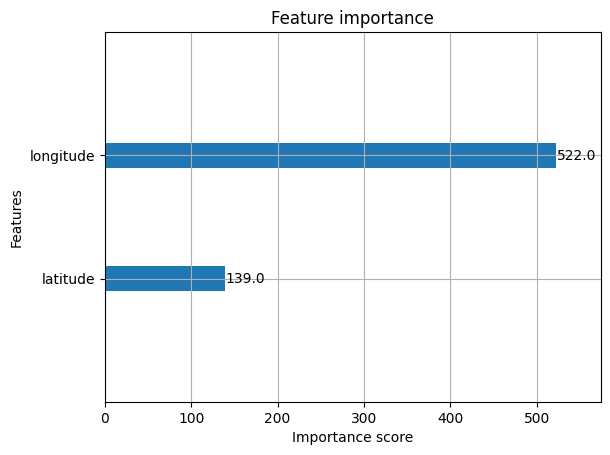

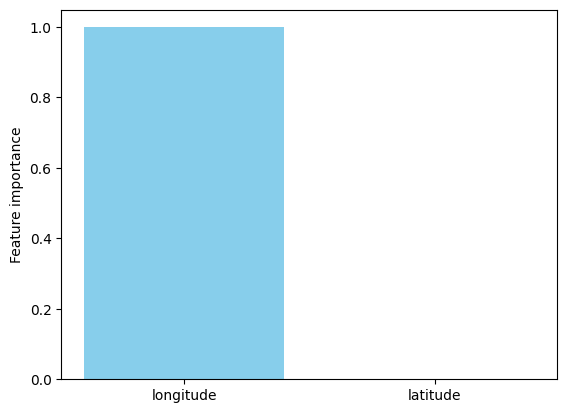

In [ ]:
plt.figure(figsize=(8,5))
plot_importance(xgb, importance_type="weight")
plt.show()

plt.bar(X_train.columns, rf.feature_importances_, color="skyblue")
plt.ylabel("Feature importance")
plt.show()

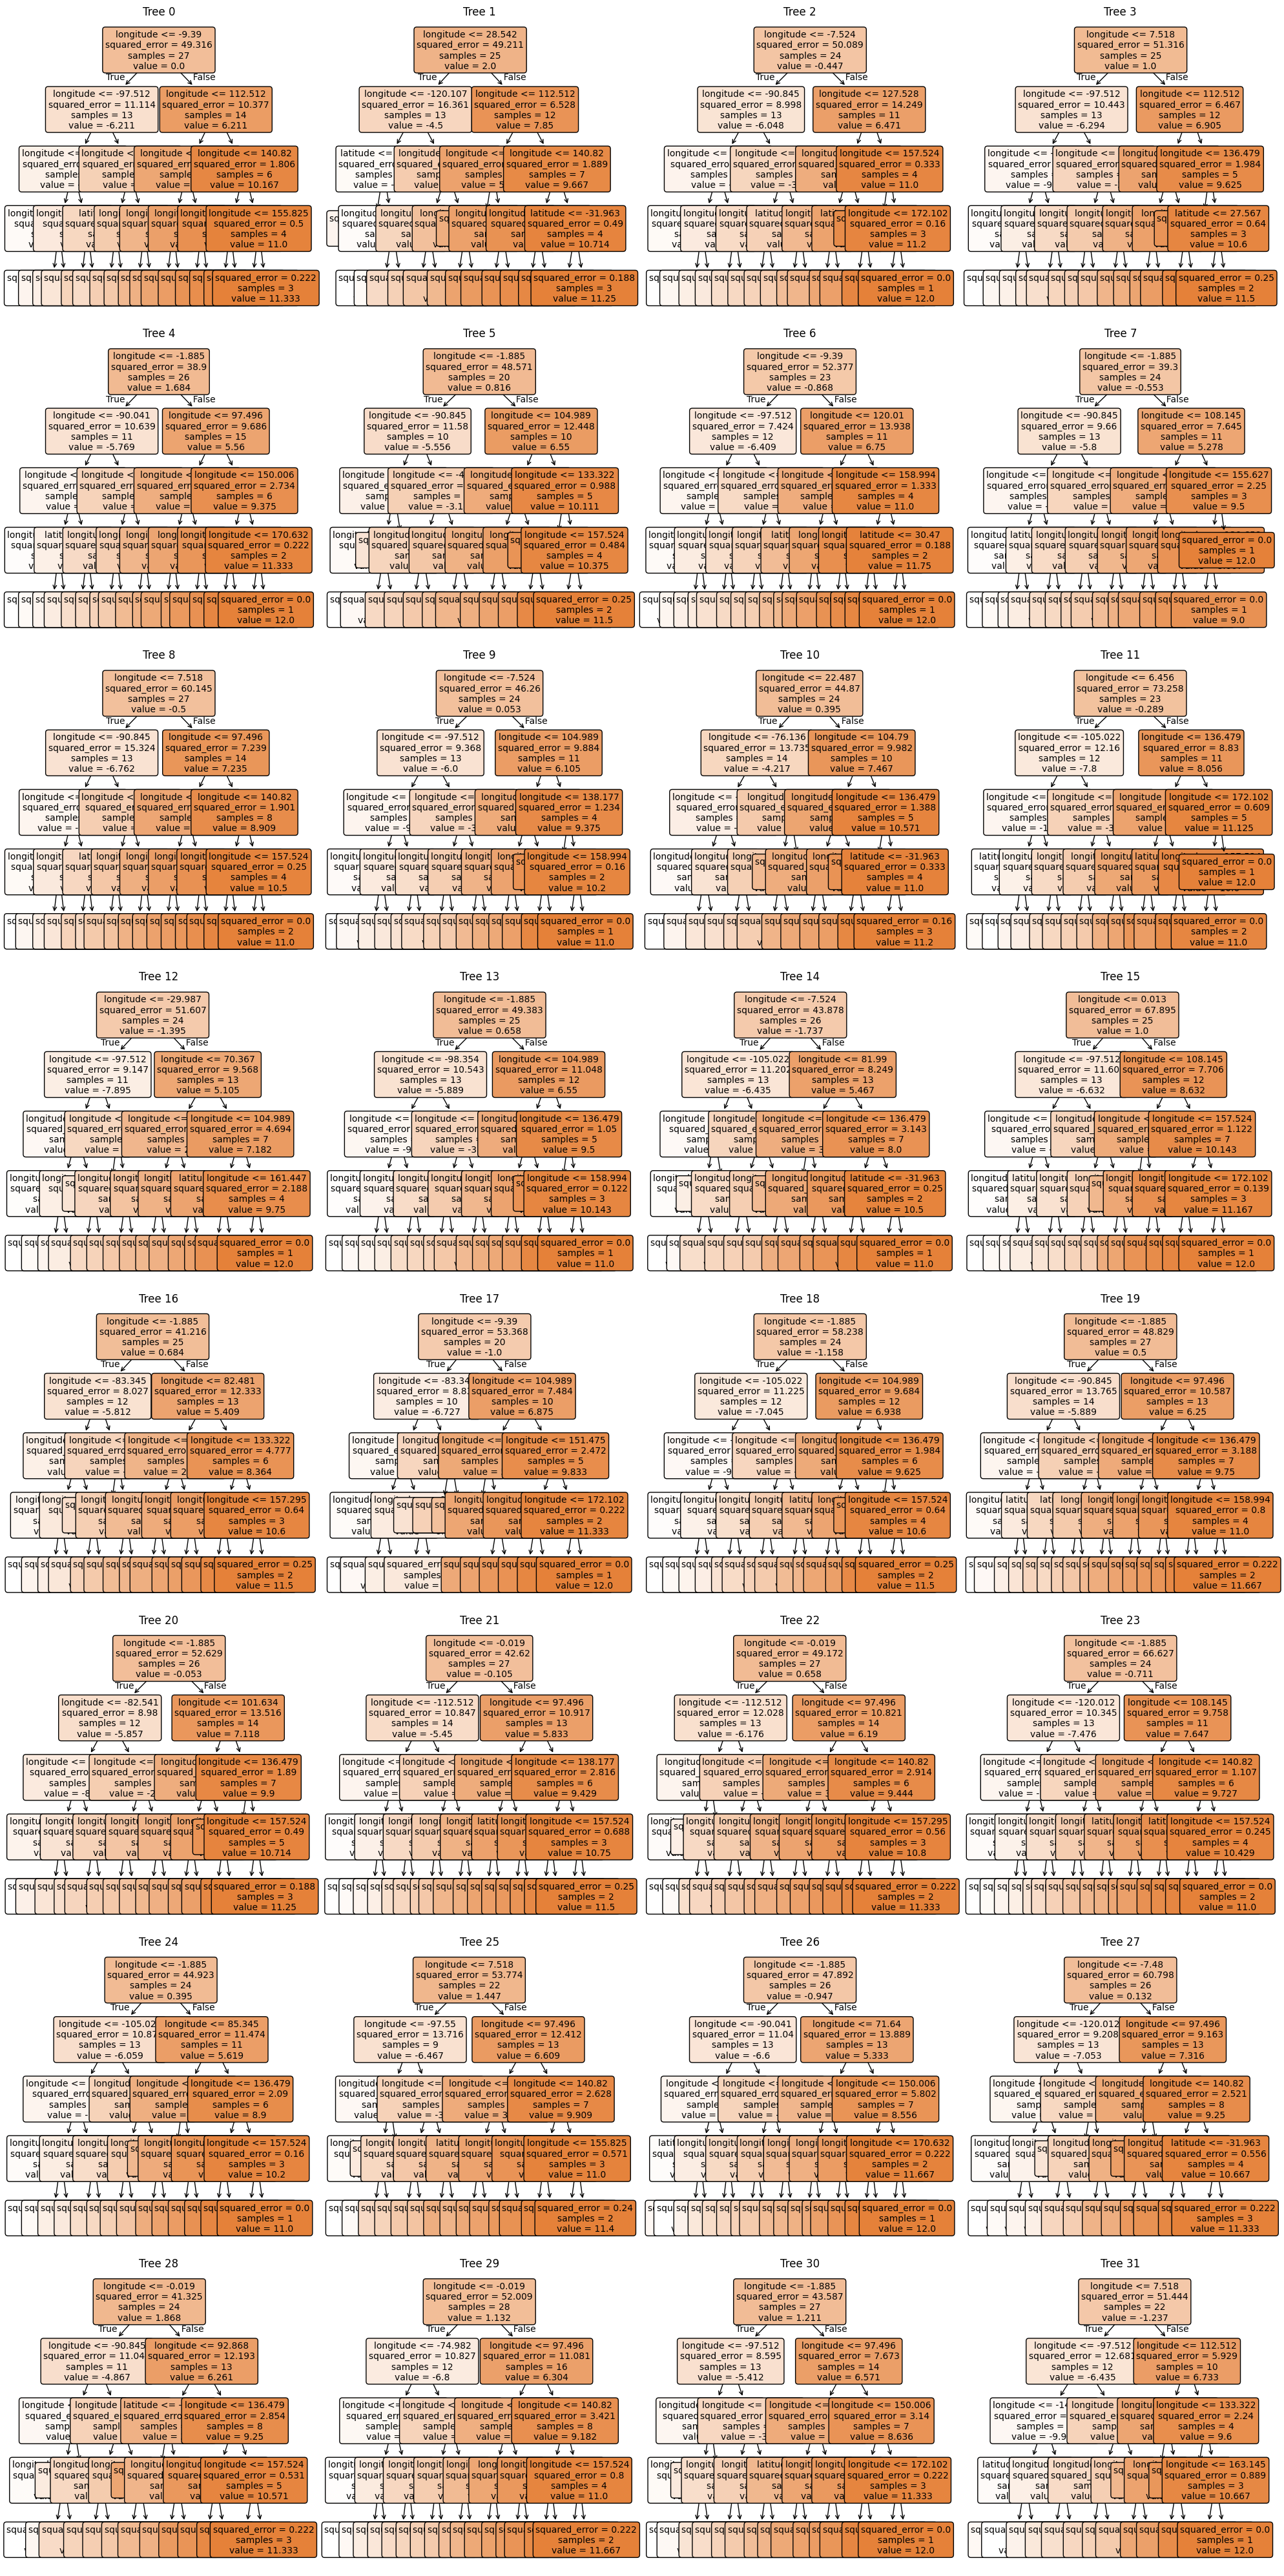

In [ ]:
random.seed(25)
n_trees = 32
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))
axes = axes.ravel()

for i in range(n_trees):
    plot_tree(
        rf.estimators_[i],
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        fontsize=10,
        ax=axes[i]
    )
    axes[i].set_title(f'Tree {i}')

plt.tight_layout()
plt.show()

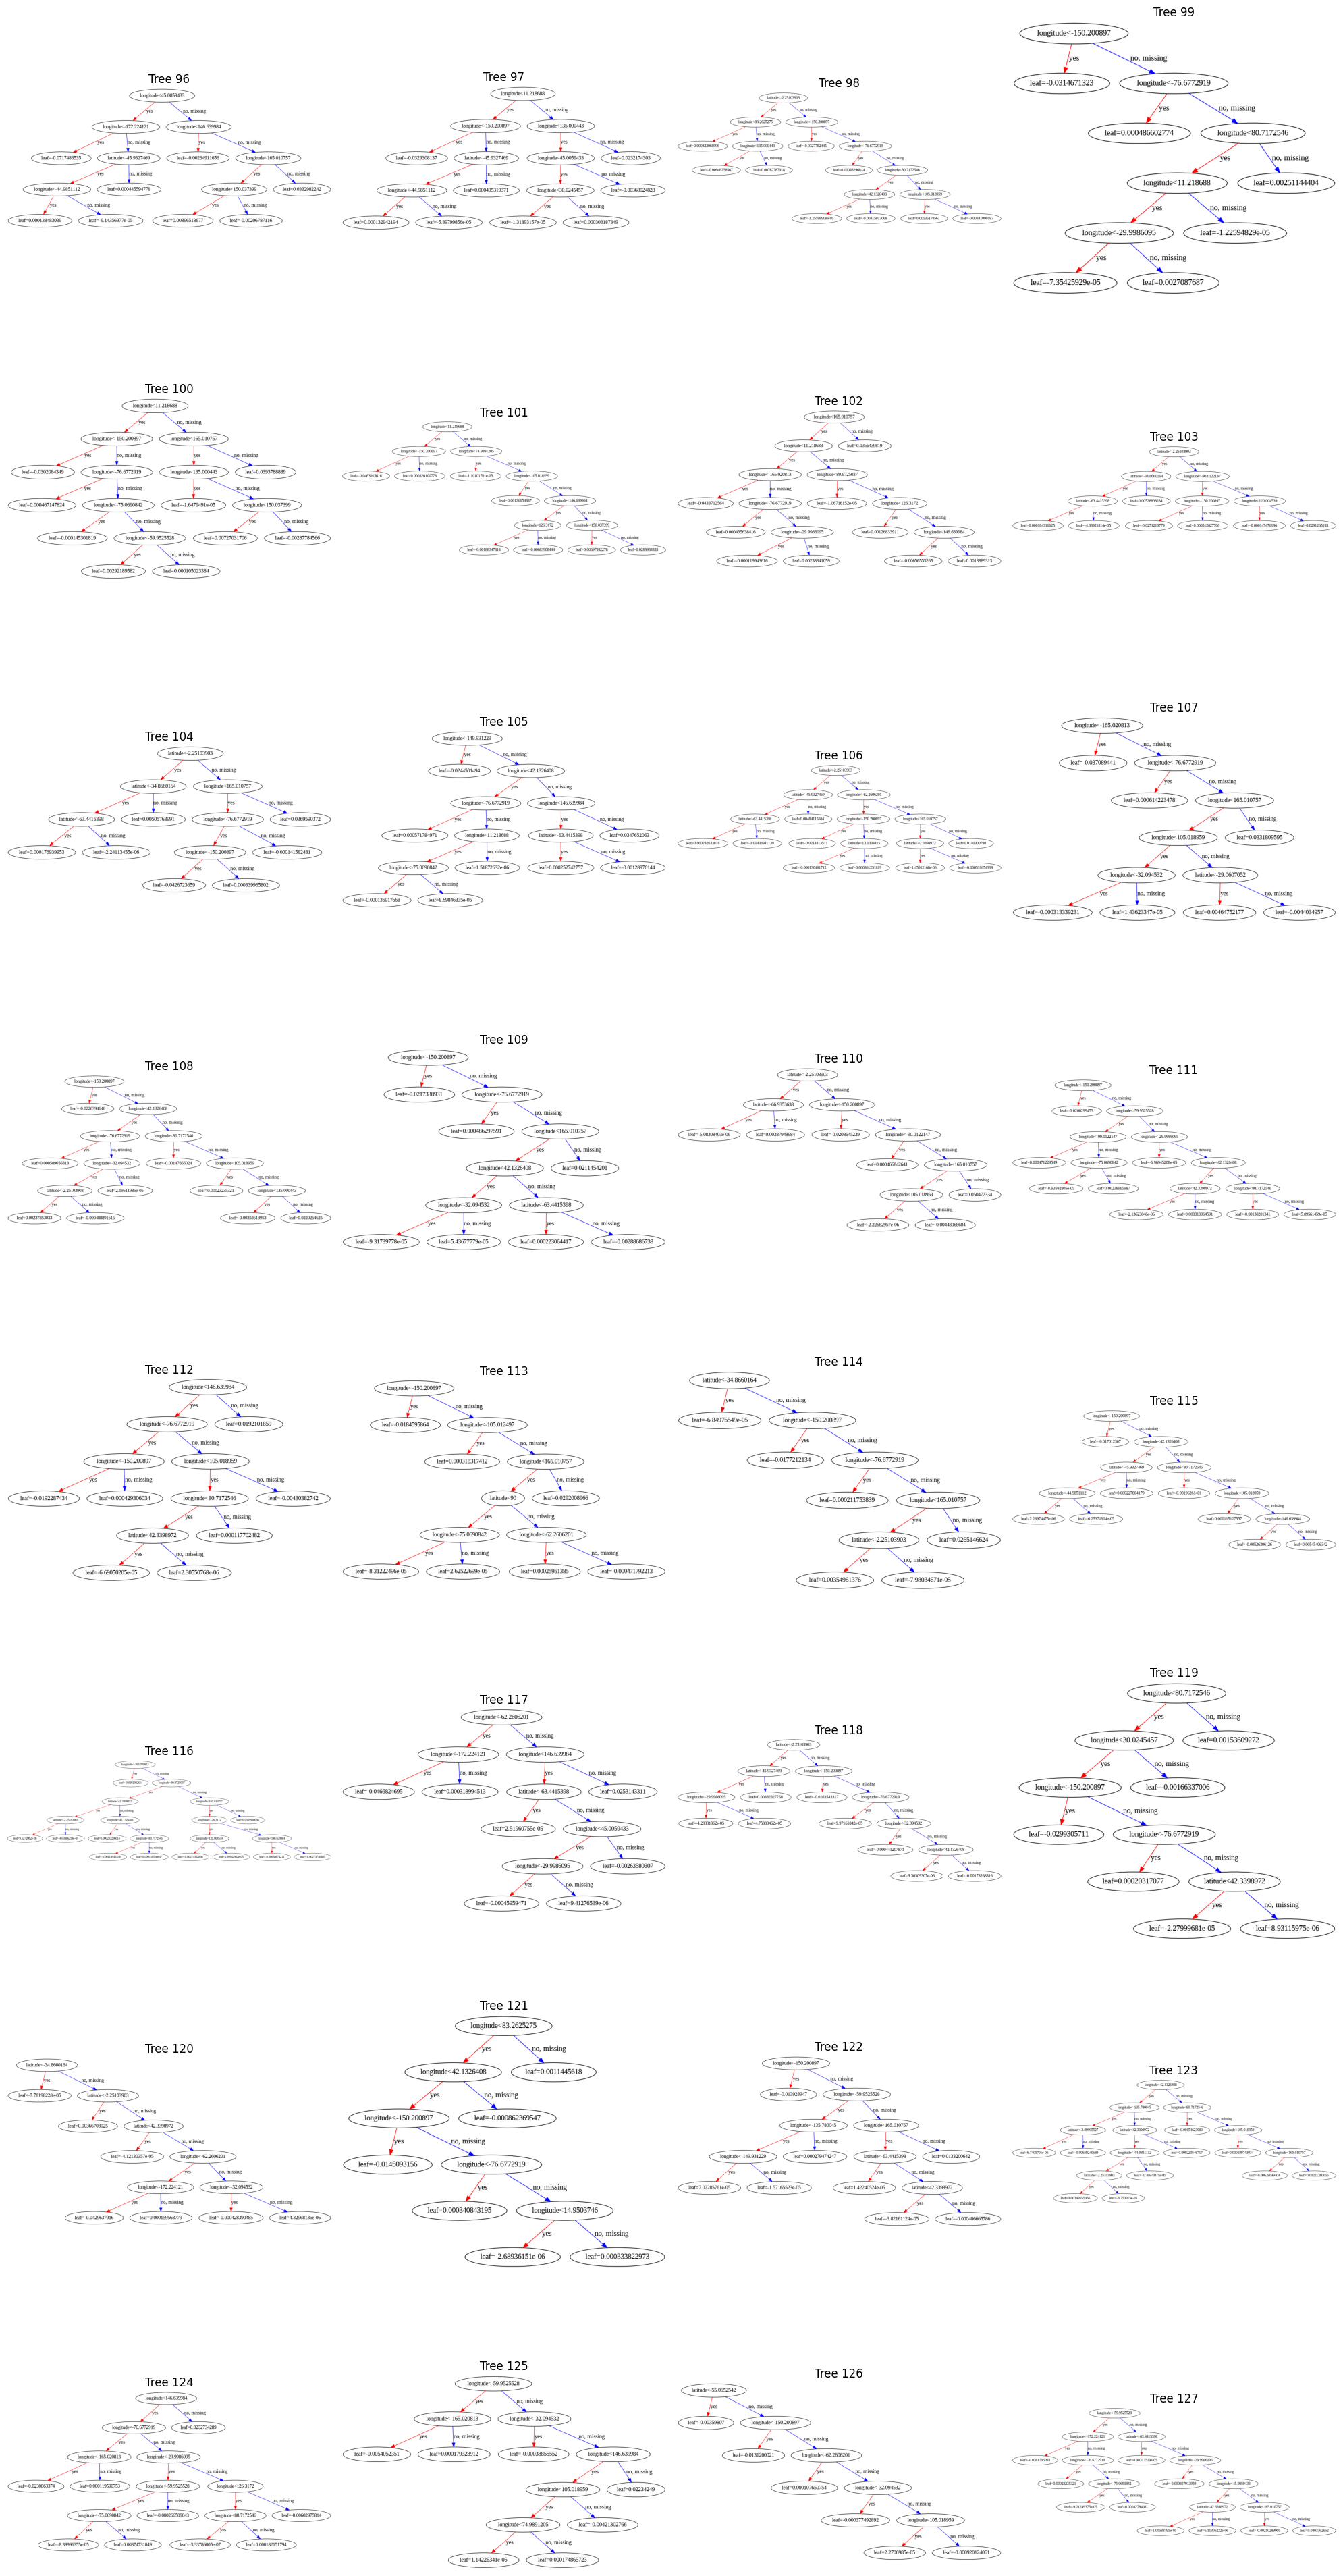

In [ ]:
n_trees = 32
start_idx = 128 - n_trees
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))
axes = axes.ravel()

for i in range(n_trees):
    tree_idx = start_idx + i
    xg_plot_tree(
        xgb,
        tree_idx=tree_idx,
        rankdir="TB",
        ax=axes[i]
    )
    axes[i].set_title(f'Tree {tree_idx}')

plt.tight_layout()
plt.show()